# Machine Learning for SAFT-$\gamma$ Mie: Fitting VLE

## Preprocessing and Testing

In [2]:
import saftgmie as saft
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn import gaussian_process
import scipy
from scipy.optimize import fsolve, least_squares, leastsq

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn import preprocessing

First, we have to generate the data we need to fit the phase diagram. With the SAFT model developed, the system can be easily defined, and populated with the desired coarse grained molecules with their respective parameters. Here, we first define two pure systems, of hexane (3 CG beads of $\lambda_r = 19.33$, $\lambda_a = 6.00$, $\sigma = 0.451\ \text{nm}$, $\epsilon/k_b = 377.012\ \text{K}$) and methane (1 CG bead of $\lambda_r = 16.391$, $\lambda_a = 6.00$, $\sigma = 0.375\ \text{nm}$, $\epsilon/k_b = 170.754\ \text{K}$). 

In [3]:
c6bead = saft.GroupType(19.32993437, 6., 0.450874, 377.0118945, shape_factor=1)
c1bead = saft.GroupType(16.39077548, 6., 0.375227, 170.7540156, shape_factor=1)

hexane = saft.Component(16.04).quick_set((c6bead, 2))
methane = saft.Component(86.1754).quick_set((c1bead, 1))

pure_methane = saft.System().quick_set((methane, 1000))
pure_hexane = saft.System().quick_set((hexane, 1000))
mixture = saft.System().quick_set((methane, 500), (hexane, 500))

  2 groups were to be added,   2 groups were added
  1 groups were to be added,   1 groups were added


After setting up the system, generate data by using the following functions: 
* `pressure (, gibbs) = .p_v_isotherm(volume, temperature=None, gibbs=False)` 
* `pressure = .p_rho_isotherm(number_density, temperature=None)` 
* `pv (,vle, gibbs) = .vapour_pressure(temperature=None, initial_guess=(1e-4,.1), get_volume=False, get_gibbs=False, print_results=True, solver=least_squares, solver_kwargs={'bounds': ((0.1,1e-3),(1e6,1e3))}, print_progress=False)`
* `volume (, density) = .single_phase_v(P, T=None, print_results=True, get_density=False)`
* `pc, tc (, vc, rhoc) = .get_critical_point(initial_guess=(3e-4, 300), get_volume=False, get_density=False, print_results=True, solver=least_squares, solver_kwargs={'bounds': ((1e-4,1), (1e2,1e3))}, xtol=1e-8, print_progress=False)`

When generating data, we have to ensure that the data points are well spread out. This has two complications:
1. Data spaces between volume and temperature spacing have to be uniform. This means that if I have say 1000 volume points per temperature for 100 temperature, the machine learning would favour fitting volume shape over accuracy in temperature. As a result, the number of data points for each isotherm have to be carefully planned out.
2. Also, the high gradient in a P-v isotherm in liquid phase is easily to extreme pressure points which results in unnecessarily high spread in data. It is hence necessary to generate points with respect to spread in pressure here instead of molar volume / density. This liquid density where the pressure gradient becomes steep also depends on the temperature, hence we have to first calculate the vapour pressure and the liquid density before generating the data points.
3. In order to generate the boundary for vapour liquid phases, we have to first find the critical temperature and pressure in order to identify the regions to avoid (near-critical).

The following code demonstrates how to locate the critical point and get values for critical pressure ($P_c$), critical temperature ($T_c$) and critical volume / density ($V_c, \rho_c$).

In [238]:
# For hexane critical point
print("="*5, "Locating critical point for hexane (19.33/6.0)", "="*5)

p_crit, t_crit, v_crit, rho_crit = pure_hexane.get_critical_point(get_volume=True, get_density=True, print_progress=True)

print(f"Located critical point at {p_crit*1e-6:6.3f} MPa and {t_crit:6.3f} K")

===== Locating critical point for hexane (19.33/6.0) =====
Current: v = 3.428e-04, T = 507.603: P, dP/dV, d2P/dV2 = 3.476e+06,-1.298e-03,3.865e-063
 active_mask: array([0, 0])
        cost: 1.3036736659731934e-21
         fun: array([-5.10605359e-11,  4.11107338e-13])
        grad: array([-4.29494366e-09,  2.62965386e-06])
         jac: array([[    85.54835439, -51499.47591687],
       [   178.05850613,    153.31229321]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 27
        njev: 24
  optimality: 1.8197462439282577e-06
      status: 3
     success: True
           x: array([1.14266897, 1.6920098 ])
Located critical point at  3.476 MPa and 507.603 K


In [12]:
# For hexane

print("="*5,"Generating hexane (19.33/6.0) data (P,v,T)","="*5)

temp_range = np.linspace(300,0.995*t_crit,200) # This was manually determined that solver still work at 477K. Try to automate this
v_liquid = np.zeros(np.size(temp_range))
v_vapour = np.zeros(np.size(temp_range))
g_eq = np.zeros(np.size(temp_range))
p_vap = np.zeros(np.size(temp_range))
# 2 phase data
tsize = np.size(temp_range)
start_time = time.time()

for i in range(tsize):
    t = temp_range[i]
    try:
        # Use previous vle as initial guess, improve speed and higher chance of success
        ig = (0.0001, 0.06) if i == 0 else vle
        pv, vle, geq = pure_hexane.vapour_pressure(t, initial_guess=ig, get_volume=True, get_gibbs=True, print_results=False)
        if abs(vle[0] - vle[1]) < 1e-6:
            print()
            print(f'VLE points solver failed to converge at meaningful results, points obtained too similar ({vle[0]:7.3e}, {vle[1]:7.3e})')
        else:
            p_vap[i] = pv
            v_liquid[i] = min(vle)
            v_vapour[i] = max(vle)
            g_eq[i] = geq
    except:
        print()
        print(f'VLE solver failed due to out of range operations. Current point aborted.')
        vle = [0.0,0.0]
    elapsed_time = time.time() - start_time
    print(f'VLE data generation at {int((i+1)*100/tsize):3d}% complete, time elapsed: {elapsed_time:5.2f} s, vle results ({vle[0]:7.3e}, {vle[1]:7.3e})', end='\r')
print()

# Take non-zero results only
temp_range = temp_range[p_vap > 0]
v_liquid = v_liquid[p_vap > 0]
v_vapour = v_vapour[p_vap > 0]
g_eq = g_eq[p_vap > 0]
p_vap = p_vap[p_vap > 0]

# Saving data, comment this block if you do not want to save the data.
df = pd.DataFrame(np.column_stack([temp_range, p_vap, v_liquid, v_vapour, g_eq]))
outputfile = 'pure-hexane-vle.csv'
df.to_csv(outputfile, index=False)
print(f'Data generation complete. Output file: {outputfile}', ' '*5)

===== Generating hexane (19.33/6.0) data (P,v,T) =====
VLE data generation at 100% complete, time elapsed: 220.40 s, vle results (2.814e-04, 4.519e-04)
Data generation complete. Output file: pure-hexane-vle.csv      


Plotting graph to show the VLE curve. This is somewhat what we are aiming to predict. For hexane, the critical temperature and pressure is 507.6 K and 3.02 MPa, and nearing the critical point, the algorithm to calculate VLE points become very difficult to converge, which results in mistaken points that doesn't fit the VLE envelope correctly. As a result, the envelope displayed will be missing the critical region. Hopefully, machine learning methods will help us kind of predict this envelop.

Text(0.5,1,'VLE envelope')

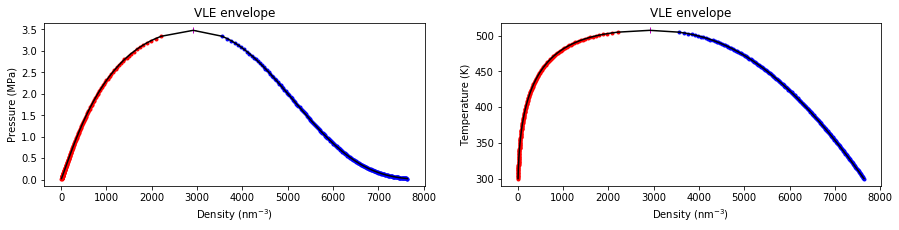

In [57]:
fig, ax = plt.subplots(1,2,figsize=(15,3))
plt.subplots_adjust(wspace=0.2)

density_ = np.concatenate([1/v_liquid, np.array([rho_crit]), np.flip(1/v_vapour)])
pressure_ = np.concatenate([p_vap, np.array([p_crit]), np.flip(p_vap)])
temperature_ = np.concatenate([temp_range, np.array([t_crit]), np.flip(temp_range)])

ax[0].plot(1/v_liquid, p_vap * 1e-6, 'b.', label='liquid boundary')
ax[0].plot(1/v_vapour, p_vap * 1e-6, 'r.', label='vapour boundary')
ax[0].plot(rho_crit, p_crit * 1e-6, 'm+', label='critcal point')
ax[0].plot(density_, pressure_ * 1e-6, 'k-', label='phase boundary')

ax[0].set_ylabel("Pressure (MPa)")
ax[0].set_xlabel("Density (nm$^{-3}$)")
ax[0].set_title("VLE envelope")

ax[1].plot(1/v_liquid, temp_range, 'b.', label='liquid boundary')
ax[1].plot(1/v_vapour, temp_range, 'r.', label='vapour boundary')
ax[1].plot(rho_crit, t_crit, 'm+', label='critcal point')
ax[1].plot(density_, temperature_, 'k-', label='phase boundary')

ax[1].set_ylabel("Temperature (K)")
ax[1].set_xlabel("Density (nm$^{-3}$)")
ax[1].set_title("VLE envelope")

Unfortunately, we can see that the phase boundary is less than ideally defined because of the lack of data that we can generate in the near critical region. One option we have here is to apply machine learning techniques such as a Gaussian process regressor (ideally for low amount of data points, but data points are noise, or error, free) to fit the vapour-liquid phase boundary. 

To apply any machine learning methods, we have to first do some preprocessing of data, which typically includes normalizing the data to mean and standard deviation of $\mu = 0.0$ and $\sigma = 1.0$. We can use the template provided by `sklearn.preprocessing`.

In [159]:
v_len = np.size(v_liquid)

p_intv = 20
t_intv = 10

rho_p = np.concatenate([1/v_liquid[0:v_len:p_intv], np.array([rho_crit]), np.flip(1/v_vapour[0:v_len:p_intv])])
rho_t = np.concatenate([1/v_liquid[0:v_len:t_intv], np.array([rho_crit]), np.flip(1/v_vapour[0:v_len:t_intv])])

P_ = np.concatenate([p_vap[0:v_len:p_intv], np.array([p_crit]), np.flip(p_vap[0:v_len:p_intv])])
T_ = np.concatenate([temp_range[0:v_len:t_intv], np.array([t_crit]), np.flip(temp_range[0:v_len:t_intv])])

x_scaler = preprocessing.StandardScaler()
x_train = x_scaler.fit_transform(rho_p.reshape((np.size(rho_p), 1)))
y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(P_.reshape((np.size(P_), 1)))

x2_scaler = preprocessing.StandardScaler()
x2_train = x2_scaler.fit_transform(rho_t.reshape((np.size(rho_t), 1)))
y2_scaler = preprocessing.StandardScaler()
y2_train = y2_scaler.fit_transform(T_.reshape((np.size(T_), 1)))

2.21**2 * Matern(length_scale=0.469, nu=1.5) + WhiteKernel(noise_level=0.00587)
0.9999956017690714 0.9975900087202189


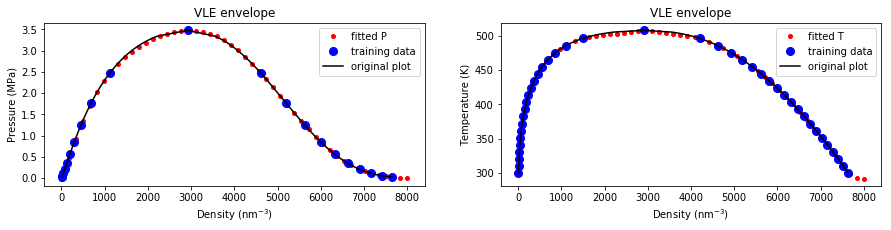

In [166]:
kern = .1 * gaussian_process.kernels.Matern(length_scale=1) + gaussian_process.kernels.WhiteKernel()
gpr = gaussian_process.GaussianProcessRegressor().fit(x_train, y_train)
gpr_t = gaussian_process.GaussianProcessRegressor(kernel=kern).fit(x2_train, y2_train)

print(gpr_t.kernel_)
print(gpr.score(x_train,y_train), gpr_t.score(x2_train, y2_train))

test_density = np.linspace(0.1,8000,50).reshape((50,1))
fitted_pressure = gpr.predict(x_scaler.transform(test_density), return_std=False) # outputs (y, std) if std=True
fitted_temp = gpr_t.predict(x2_scaler.transform(test_density), return_std=False)

fig, ax = plt.subplots(1,2,figsize=(15,3))
plt.subplots_adjust(wspace=0.2)
ax[0].plot(test_density, y_scaler.inverse_transform(fitted_pressure)*1e-6, 'r.', markersize=8, label='fitted P')
ax[0].plot(rho_p, P_*1e-6, 'bo', markersize=8, label='training data')
ax[0].plot(density_, pressure_*1e-6, 'k-', label='original plot')
# ax2 = ax[0].twinx()
# ax2.plot(test_density, stdev, 'b--')
# ax2.set_ylabel("Standard deviation")
ax[0].set_ylabel("Pressure (MPa)")
ax[0].set_xlabel("Density (nm$^{-3}$)")
ax[0].set_title("VLE envelope")
ax[0].legend()

ax[1].plot(test_density, y2_scaler.inverse_transform(fitted_temp), 'r.', markersize=8, label='fitted T')
ax[1].plot(rho_t, T_, 'bo', markersize=8, label='training data')
ax[1].plot(density_, temperature_, 'k-', label='original plot')
# ax2 = ax[1].twinx()
# ax2.plot(test_density, stdev, 'b--')
# ax2.set_ylabel("Standard deviation")
ax[1].set_ylabel("Temperature (K)")
ax[1].set_xlabel("Density (nm$^{-3}$)")
ax[1].set_title("VLE envelope")
ax[1].legend()

Another way to test the regression is using support vector regression. However, this might be less useful because support vector regression excels when there is some noise due to accepting a small error tolerance, while minimizing error of points outside of the tolerable margin. Either way, we could test to see how support vector machine work. In both gaussian regression and support vector regression, we use radial basis function (RBF) as kernel transformation to fit our data.

Other available options for GPR are: `ConstantKernel` can be use with `Product` kernel to scale another kernel; `WhiteKernel` can be added to another kernel with `Sum` kernel to introduce noise, other kernels include `RBF`, `Matern`, `RationalQuadratic`, `ExpSineSquared` and `DotProduct`.

Other available options for SVR are: `linear`, `poly`, `rbf`, `sigmoid`, `precomputed` or a callable. If none is given, `rbf` will be used. If a callable is given it is used to precompute the kernel matrix.

0.9969253102202006 0.9743361959535964


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


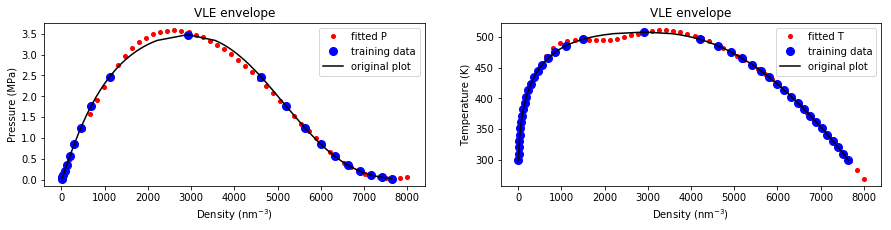

In [181]:
svr_p = svm.SVR(C=10, epsilon=0.01) # kernel is rbf by default
svr_t = svm.SVR(C=1000, epsilon=0.01)

svr_xt = x_train#.reshape((np.size(x_train),))
svr_yt = y_train#.reshape((np.size(y_train),))
svr_xt2 = x2_train#n.reshape((np.size(x2_train),))
svr_yt2 = y2_train#.reshape((np.size(y2_train),))

svr_p.fit(svr_xt, svr_yt)
svr_t.fit(svr_xt2, svr_yt2)

print(svr_p.score(svr_xt,svr_yt), svr_t.score(svr_xt2, svr_yt2))

svr_test_density = np.linspace(0.1,8000,50).reshape((50,1))
svr_fitted_pressure = svr_p.predict(x_scaler.transform(svr_test_density))
svr_fitted_temp = svr_t.predict(x2_scaler.transform(svr_test_density))

fig, ax = plt.subplots(1,2,figsize=(15,3))
plt.subplots_adjust(wspace=0.2)
ax[0].plot(svr_test_density, y_scaler.inverse_transform(svr_fitted_pressure)*1e-6, 'r.', markersize=8, label='fitted P')
ax[0].plot(rho_p, P_*1e-6, 'bo', markersize=8, label='training data')
ax[0].plot(density_, pressure_*1e-6, 'k-', label='original plot')
ax[0].set_ylabel("Pressure (MPa)")
ax[0].set_xlabel("Density (nm$^{-3}$)")
ax[0].set_title("VLE envelope")
ax[0].legend()

ax[1].plot(svr_test_density, y2_scaler.inverse_transform(svr_fitted_temp), 'r.', markersize=8, label='fitted T')
ax[1].plot(rho_t, T_, 'bo', markersize=8, label='training data')
ax[1].plot(density_, temperature_, 'k-', label='original plot')
ax[1].set_ylabel("Temperature (K)")
ax[1].set_xlabel("Density (nm$^{-3}$)")
ax[1].set_title("VLE envelope")
ax[1].legend()

Now, with the relevant data for liquid and vapour density / molar volume, we can generate data within the ranges using the SAFT-$\gamma$ Mie EoS for each respective phase (vapour, liquid, v-l). For the liquid region, it would be more reasonable to generate data by intervals in pressure due to the extremely steep gradient for pressure at very small change in volume. For the vapour-liquid and vapour region, we should generate in intervals of volume, density or log of volume, depending which would give use better results. The following code would be necessary to generate data used for classification.

## Step-by-step approach towards a ML model for SAFT-$\gamma$ Mie

At this point, we could also easily attempt to use deep learning neural network to fit the VLE envelope. With enough neurons, this could be a relatively easy regression and a relatively nice fit could be achieved. At this time, it would be ideal to venture into adding an additional input, such as the forcefield parameter $\lambda$ in SAFT-$\gamma$ Mie. In order to generate data for fitting, we will have to create multiple systems at different forcefield parameters, as well as do units reduction to remove the effects of $\sigma$ and $\epsilon$ by converting $P$, $T$ and $\rho$ (or $\rho_s$ for nicer corelations) to dimensionless units: $T^* = \frac{kT}{\epsilon}$, $P* = \frac{P\sigma^3}{\epsilon}$, $\rho^* = \rho \sigma^3$ and $v^* = \frac{v}{\sigma^3}$.

At this point, we can start establishing the proper steps to apply machine learning techniques to finding vapour liquid envelope. Also, this would be a good point to decide how much data do I need, as well as different approaches which could be used here. We split our direction into two different testing: machine learning regression, and machine learning classification.
0. Before everything, we have to test the effect of using dimensionless properties. Because the SAFT package coded was based on SI units, it is important to see if having same reduced properties for different $\sigma$ and $\epsilon$ but the same forcefield parameters will result in the same values generated. Also, we could test this by using a simple regression for critical pressure and temperature.

**For Regression**
1. First, we should be clear of which properties we are predicting from what as there is only one degree of freedom in the system. Technically, we could build a machine learning model to predict $v_v$, $v_l$ and $T$ based on $P_v$, or use simply $v$ to return $P_v$ and $T$ (but makes less sense objectively). So testing single input -> multiple outputs model for a single component is necessary. We could use multiple regressors as previous section, or we could use a deep learning network. Note: SVR outputs only in a single dimension, while GPR could potential handle multiple outputs.
2. Next, we introduce different lambda parameters as an additional dimension on top of $v$, $Pv$ or $T$, for a constant number of segments ($m_s$), for example 2. There is a few things we could try here: using different intervals of lambda and how we spread our data (esp. since near critical region has less data). For one, we could use discrete lambda values (9,10,..24) as training data and validate with fitted real molecules like n-hexane. This is the principle behind our future attempt translate transport properties from MD simulations to a SAFT-$\gamma$ Mie 'blackbox'.
3. And the last step is to bring in the number of CG beads $m_s$. Of course, the spread of data here only makes sense for integer values, but do think about the impact and benefits of considering decimal values at this point.
4. Following this, we can repeat the process for regression to find state point instead of VLE envelope, e.g. using $v$ and $T$ to get $P$. This would be beneficial to do after completing classification.

**For Classification**
1. For classification, the degree of freedom is one less: we would need both $v$ and $T$ to predict $P$, or any of the two to predict the other. However, since we are only doing phase classification (V, L, or V-L), we basically only need two of the state points which we could easily build model for each of them. First, we would test the classification methods for 2 inputs to 1 output for a single component before introducing higher dimensions into the problem. 
2. Secondly, we will repeat the same process as we did for VLE envelope regression and introduce the forcefield parameter $\lambda$ (note at this point we are only test for $\lambda_r$, but we could potentially introduce $\lambda_a$ as well). The same considerations for regression should apply here as well.
3. And for the last step, we can bring in the number of CG beads per molecule $m_s$ as an input for classification.
4. Also, it is important to find out what is a good way of figuring out the bounds of classification and representing them visually. This will also be very helpful to compare the ML model found using regression.

### Generation and regression of critical P, T data 

In [2]:
from IPython.utils import io

pure_systems = []
sig_scale = 0.3
epsi_scale = 250.
kb = 1.38064852e-23
nmtom = 1e-9
avo = 6.02214086e23

ms_data = np.array([])
rep_data = np.array([])
with io.capture_output() as captured:
    for ms in [1,2,3,4,6,8,10,12,14,16,20]:
        for rep in [8,10,12,14,16,20,24,28,32]:
            ms_data = np.append(ms_data, ms)
            rep_data = np.append(rep_data, rep)
            st = f'rep={rep:5.2f},ms={ms:d}'
            gt = saft.GroupType(rep, 6., sig_scale, epsi_scale, shape_factor=1)
            # 0.3nm and 300K is scaling factor for now
            cm = saft.Component(10.).quick_set((gt, ms)) 
            pure_systems.append(saft.System().quick_set((cm, 1000)))
print(len(pure_systems))

99


In [23]:
pc_data = np.array([])
tc_data = np.array([])
rhoc_data = np.array([])

start_time = time.time()
for i in range(len(pure_systems)):
    pure_sys = pure_systems[i]
    t_init = (i+1)**0.7 * epsi_scale
    v_init = 2*ms_data[i]*(sig_scale * nmtom)**3 * avo
    v_range = np.logspace(math.log10(v_init/2), math.log10(v_init)+1, 30)
    (pc, tc, rhoc) = pure_sys.critical_point(initial_t=t_init, initial_v=v_init, v_nd=v_range, get_volume=False,
                                             get_density=True, print_results=False, print_progress=False)
    pc_s = pc * (sig_scale * nmtom)**3 / (epsi_scale * kb)
    tc_s = tc / epsi_scale
    rhoc_s = rhoc * avo * (sig_scale * nmtom)**3
    elapsed_time = time.time() - start_time
    print(f'Current status: rep={rep_data[i]:5.2f},ms={int(ms_data[i]):d}, results: ({pc_s:5.3f}, {tc_s:5.3f}, {rhoc_s:5.3f}), elapsed time: {elapsed_time:6.3f}s')
    pc_data = np.append(pc_data, pc_s)
    tc_data = np.append(tc_data, tc_s)
    rhoc_data = np.append(rhoc_data, rhoc_s)

Current status: rep= 8.00,ms=1, results: (0.176, 1.783, 0.290), elapsed time: 137.311s
Current status: rep=10.00,ms=1, results: (0.146, 1.478, 0.297), elapsed time: 266.423s
Current status: rep=12.00,ms=1, results: (0.130, 1.310, 0.310), elapsed time: 447.890s
Current status: rep=14.00,ms=1, results: (0.120, 1.203, 0.321), elapsed time: 590.294s
Current status: rep=16.00,ms=1, results: (0.114, 1.127, 0.321), elapsed time: 784.723s
Current status: rep=20.00,ms=1, results: (0.106, 1.027, 0.321), elapsed time: 1003.775s
Current status: rep=24.00,ms=1, results: (0.101, 0.963, 0.332), elapsed time: 1233.894s
Current status: rep=28.00,ms=1, results: (0.097, 0.918, 0.354), elapsed time: 1475.776s
Current status: rep=32.00,ms=1, results: (0.094, 0.884, 0.356), elapsed time: 1730.675s
Current status: rep= 8.00,ms=2, results: (0.110, 2.553, 0.131), elapsed time: 1954.156s
Current status: rep=10.00,ms=2, results: (0.090, 2.052, 0.134), elapsed time: 2093.800s
Current status: rep=12.00,ms=2, resul

Current status: rep=14.00,ms=20, results: (0.006, 3.116, 0.006), elapsed time: 13362.162s
Current status: rep=16.00,ms=20, results: (0.005, 2.828, 0.006), elapsed time: 13475.274s
Current status: rep=20.00,ms=20, results: (0.004, 2.462, 0.006), elapsed time: 13608.041s
Current status: rep=24.00,ms=20, results: (0.005, 2.459, 0.003), elapsed time: 13715.602s
Current status: rep=28.00,ms=20, results: (0.005, 2.477, 0.003), elapsed time: 13826.068s
Current status: rep=32.00,ms=20, results: (0.006, 2.494, 0.003), elapsed time: 13921.871s


In [24]:
# Saving generated critical data to 
df = pd.DataFrame(np.column_stack([rep_data, ms_data, pc_data, tc_data, rhoc_data]))
outputfile = 'saftgmie_critical_data.csv'
df.to_csv(outputfile, index=False, header=['lambda_r', 'm_s', 'p_c', 't_c', 'rho_c'])
print(f'Data generation complete. Output file: {outputfile}', ' '*5)

Data generation complete. Output file: saftgmie_critical_data.csv      


In [140]:
# Reading data
inputfile = 'saftgmie_critical_data.csv'
df = pd.read_csv(inputfile)

rep_data = df.iloc[:,0].values
ms_data = df.iloc[:,1].values
pc_data = df.iloc[:,2].values
tc_data = df.iloc[:,3].values
rhoc_data = df.iloc[:,4].values

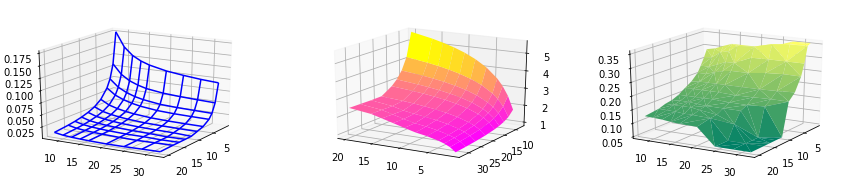

In [4]:
fig = plt.figure(figsize=(15,3))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ms_only = np.array([1,2,3,4,6,8,10,12,14,16,20])
rep_only = np.array([8,10,12,14,16,20,24,28,32])

ax1.plot_wireframe(ms_data.reshape((11,9)),rep_data.reshape((11,9)),pc_data.reshape((11,9)), color='blue')
ax2.plot_surface(ms_data.reshape((11,9)),rep_data.reshape((11,9)),tc_data.reshape((11,9)), rstride=1, cstride=1,
                cmap='spring', edgecolor='none')
#ax3.scatter(ms_data,rep_data,rhoc_data, c='m', marker='.')
rhocs_data = rhoc_data * ms_data
ax3.plot_trisurf(ms_data,rep_data,rhocs_data,linewidth=0.2, antialiased=True,cmap='summer')

ax1.view_init(20, 30)
ax2.view_init(20, 120)
ax3.view_init(20, 30)

After generating data for critical point, we can begin our first regression by training the data using these generated critical points. For evaluation, we can obtain the critical points of real fluids with their respective critical points and check the absolute deviation.

In [5]:
# Setting up basic deep learning class
class SimpleNet(nn.Module):
    def __init__(self, input_output, layers, activation_func=None):
        super().__init__()
        input_dim = input_output[0]
        output_dim = input_output[1]
        self.beta = nn.ModuleList()
        self.sig = nn.ModuleList() if activation_func is not None else None
        while (activation_func is not None) and len(activation_func) < len(layers):
            activation_func.append(activation_func[-1])
            
        for i in range(len(layers)):
            if i == 0:
                self.beta.append(nn.Linear(input_dim, layers[i]))

            if i < len(layers)-1:
                self.beta.append(nn.Linear(layers[i], layers[i+1]))
                if self.sig is not None:
                    self.sig.append(activation_func[i])
                
            else:
                self.beta.append(nn.Linear(layers[i],output_dim))
        self.layers = len(self.beta)

    def forward(self, x):
        for i in range(self.layers):
            f = self.beta[i]
            if i == 0 or i == self.layers - 1 or self.sig is None:
                x = f(x)
            else:
                a = self.sig[i-1]
                x = a(f(x))
        return x

In [63]:
# Regression to get critical data

# Deep Learning
x_scaler = preprocessing.StandardScaler()
x_train = x_scaler.fit_transform(np.column_stack([ms_data, rep_data]))
y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(pc_data.reshape((np.size(pc_data), 1)))

x = torch.from_numpy(x_train).float()
y = torch.from_numpy(y_train).float()
xv = torch.from_numpy(x_train).float()
yv = torch.from_numpy(y_train).float()

model = SimpleNet((2,1), [30,10], [nn.Tanh(), nn.ReLU()])
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 0

In [64]:
for i in range(10000):
    model.train()
    optimizer.zero_grad()

    y_ = model(x)
    loss = criterion(y_, y)

    # print('epoch: ', epoch,' loss: ', loss.item())
    loss.backward()
    optimizer.step()
    epochs += 1

model.eval()
with torch.no_grad():
    yv_ = model(xv)
    loss = criterion(yv_, yv)

test_ms = np.repeat(np.linspace(1,20,200), 200)
test_rep = np.tile(np.linspace(8,32,200), 200)
x_test = torch.from_numpy(x_scaler.transform(np.column_stack([test_ms, test_rep]))).float()

with torch.no_grad():
    y_test = model(x_test)

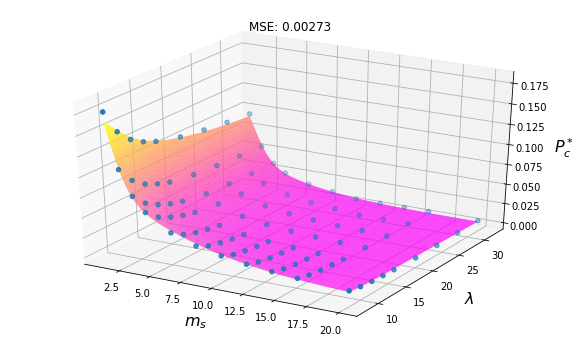

In [72]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')
inputs = x_scaler.inverse_transform(xv.numpy())
# ax.scatter(inputs[:,0], inputs[:,1], y_scaler.inverse_transform(yv_.numpy()), '.', label='pred')
ax.scatter(inputs[:,0], inputs[:,1], y_scaler.inverse_transform(yv.numpy()), '.', label='data')

ax.plot_surface(test_ms.reshape(200,200), test_rep.reshape(200,200),
                y_scaler.inverse_transform(y_test.numpy()).reshape(200,200), rstride=1, cstride=1,
                cmap='spring', edgecolor='none', label='data')

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('$m_s$',fontsize=16,labelpad=10)
ax.set_ylabel('$\lambda$',fontsize=16,labelpad=10)
ax.set_zlabel('$P_c^*$',fontsize=16,labelpad=10)
ax.set_title(f"MSE: {loss.item():0.5f}")

fig.savefig('pcrit.png', bbox_inches="tight", dpi=600, transparent=True, pad_inches=0)

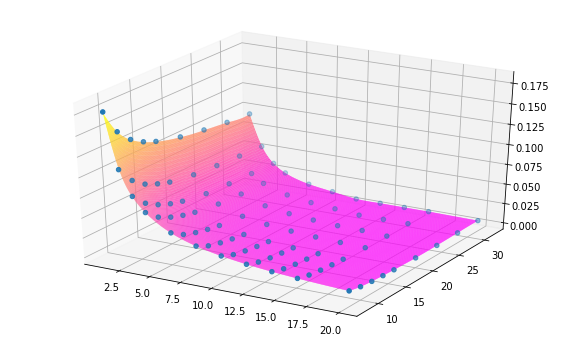

In [9]:
# Gaussian Process Regression
kern = .1 * gaussian_process.kernels.Matern(length_scale=1) + gaussian_process.kernels.WhiteKernel()
gpr = gaussian_process.GaussianProcessRegressor(kernel=kern).fit(x_train, y_train)

test_ms = np.repeat(np.linspace(1,20,200), 200)
test_rep = np.tile(np.linspace(8,32,200), 200)
test_inputs = np.column_stack([test_ms, test_rep])

fitted_pc = gpr.predict(x_scaler.transform(test_inputs), return_std=False) # outputs (y, std) if std=True

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(ms_data, rep_data, pc_data, '.', label='pred')
ax.plot_surface(test_ms.reshape(200,200), test_rep.reshape(200,200),
                y_scaler.inverse_transform(fitted_pc).reshape(200,200), rstride=1, cstride=1,
                cmap='spring', edgecolor='none', label='data')

This seem to work really well. Now let's try both GPR and ANN for multiple outputs. While it is definitely workable to use multiple models to predict one output each (probably will be the case for SVR because it only allows one output variable), we should see if multiple outputs will have an effect on the result of these two techniques. Let's test this out and see:

In [141]:
# 3 outputs critical data model

x_scaler = preprocessing.StandardScaler()
x_train = x_scaler.fit_transform(np.column_stack([ms_data, rep_data]))
y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(np.column_stack([pc_data, tc_data, rhoc_data*ms_data]))

x = torch.from_numpy(x_train).float()
y = torch.from_numpy(y_train).float()
xv = torch.from_numpy(x_train).float()
yv = torch.from_numpy(y_train).float()

model3 = SimpleNet((2,3), [30,10], [nn.Tanh(), nn.ReLU()])
optimizer = optim.SGD(model3.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 0

In [94]:
for i in range(10000):
    model3.train()
    optimizer.zero_grad()

    y_ = model3(x)
    loss = criterion(y_, y)

    # print('epoch: ', epoch,' loss: ', loss.item())
    loss.backward()
    optimizer.step()
    epochs += 1

model3.eval()
with torch.no_grad():
    yv_ = model3(xv)
    loss = criterion(yv_, yv)

test_ms = np.repeat(np.linspace(1,20,30), 30)
test_rep = np.tile(np.linspace(8,32,30), 30)
x_test = torch.from_numpy(x_scaler.transform(np.column_stack([test_ms, test_rep]))).float()

with torch.no_grad():
    y_test = model3(x_test)

In [103]:
kb = 1.38064852e-23
nmtom = 1e-9
avo = 6.02214086e23

# ms, lam, sig, epsi, pcrit, tcrit, rhocrit
prop = np.array((1, 34.29, 0.4871, 426.08, 376.20, 4.77, 219.98, 0.04410))
nhex = np.array((2, 19.57, 0.4508, 376.35, 515.29, 3.44, 241.16, 0.08618))
noct = np.array((3, 16.14, 0.4227, 333.70, 576.72, 2.77, 227.83, 0.11423))
ndec = np.array((3, 20.92, 0.4584, 415.19, 626.37, 2.31, 219.85, 0.14229))

check_data = np.vstack([prop, nhex, noct, ndec])
check_data[:,4] = check_data[:,4] / check_data[:,3]
check_data[:,5] = check_data[:,5] * 1e6 * (check_data[:,2] * nmtom)**3 / (check_data[:,3] * kb)
check_data[:,6] = check_data[:,6] * check_data[:,0] / check_data[:,7] * avo * (check_data[:,2] * nmtom)**3

check_x = torch.from_numpy(x_scaler.transform(check_data[:,0:2])).float()
check_y = np.column_stack([check_data[:,5],check_data[:,4],check_data[:,6]])


pc_d = np.array([])
tc_d = np.array([])
rhoc_d = np.array([])
start_time = time.time()
for ms,rep,sig,epsi in check_data[:,0:4]:
    gt = saft.GroupType(rep, 6., sig, epsi, shape_factor=1)
    cm = saft.Component(10.).quick_set((gt, int(ms))) 
    psys = saft.System().quick_set((cm, 1000))
    
    t_init = (ms+1)**0.7 * epsi
    v_init = 2*ms*(sig * nmtom)**3 * avo
    v_range = np.logspace(math.log10(v_init/2), math.log10(v_init)+1, 30)
    (pc, tc, rhoc) = psys.critical_point(initial_t=t_init, initial_v=v_init, v_nd=v_range, get_volume=False,
                                             get_density=True, print_results=False, print_progress=True)
    pc_s = pc * (sig * nmtom)**3 / (epsi * kb)
    tc_s = tc / epsi
    rhoc_s = rhoc * avo * (sig * nmtom)**3
    elapsed_time = time.time() - start_time
    print(f'Current status: rep={rep:5.2f},ms={int(ms):d}, results: ({pc_s:5.3f}, {tc_s:5.3f}, {rhoc_s:5.3f}), elapsed time: {elapsed_time:6.3f}s')
    pc_d = np.append(pc_d, pc_s)
    tc_d = np.append(tc_d, tc_s)
    rhoc_d = np.append(rhoc_d, rhoc_s)
    
check_y2 = np.column_stack([pc_d, tc_d, rhoc_d])
print(check_y)
print(check_y2)


  1 groups were to be added,   1 groups were added
Current: T = 369.851: max dP/dV = -2.576e-03
Current status: rep=34.29,ms=1, results: (0.093, 0.868, 0.358), elapsed time: 135.307s
  2 groups were to be added,   2 groups were added
Current: T = 503.929: max dP/dV = -8.149e-04
Current status: rep=19.57,ms=2, results: (0.061, 1.339, 0.162), elapsed time: 294.579s
  3 groups were to be added,   3 groups were added
Current: T = 568.361: max dP/dV = -3.199e-04
Current status: rep=16.14,ms=3, results: (0.044, 1.703, 0.087), elapsed time: 423.694s
  3 groups were to be added,   3 groups were added
Current: T = 616.978: max dP/dV = -3.236e-041
Current status: rep=20.92,ms=3, results: (0.038, 1.486, 0.096), elapsed time: 577.590s
[[0.09371271 0.88293278 0.34717617]
 [0.0606506  1.36917763 0.30876738]
 [0.0454085  1.72825892 0.27214455]
 [0.03881645 1.5086346  0.26887974]]
[[0.09285503 0.86803093 0.35802607]
 [0.06097596 1.33899146 0.16165954]
 [0.04405866 1.70320918 0.08702788]
 [0.03847676 1

In [112]:
with torch.no_grad():
    check_y_ = model3(check_x)

pred = y_scaler.inverse_transform(check_y_.numpy())
print(pred)
check_y2 = np.array([[0.09285503, 0.86803093, 0.35802607],
                     [0.06097596, 1.33899146, 0.16165954],
                     [0.04405866, 1.70320918, 0.08702788],
                     [0.03847676, 1.48601264, 0.09649871]])
check_y2[:,2] = check_y2[:,2] * check_data[:,0]
print(abs(pred-check_y)/check_y*100)
print(abs(pred-check_y2)/check_y2*100)

aad = np.minimum(abs(pred-check_y)/check_y*100, abs(pred-check_y2)/check_y2*100)
print(aad)

[[0.08134141 0.81215614 0.34451824]
 [0.06750288 1.2916511  0.30653968]
 [0.04465684 1.6537576  0.260034  ]
 [0.04053761 1.5274919  0.27704844]]
[[13.2013042   8.01608494  0.76558387]
 [11.297954    5.66226733  0.72148022]
 [ 1.65534291  4.31077441  4.45004498]
 [ 4.43410685  1.24995981  3.03804866]]
[[12.39956716  6.43695832  3.77286094]
 [10.70408503  3.53552145  5.18973253]
 [ 1.35767973  2.90343714  0.40203403]
 [ 5.35609196  2.79131456  4.2997781 ]]
[[12.39956716  6.43695832  0.76558387]
 [10.70408503  3.53552145  0.72148022]
 [ 1.35767973  2.90343714  0.40203403]
 [ 4.43410685  1.24995981  3.03804866]]


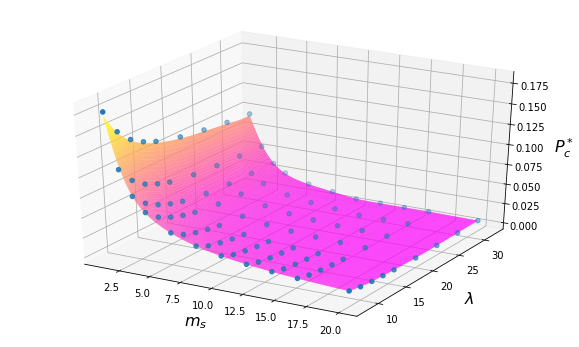

In [145]:
# Gaussian Process Regression
kern = .1 * gaussian_process.kernels.Matern(length_scale=1) + gaussian_process.kernels.WhiteKernel()
gpr = gaussian_process.GaussianProcessRegressor(kernel=kern).fit(x_train, y_train)

test_ms = np.repeat(np.linspace(1,20,200), 200)
test_rep = np.tile(np.linspace(8,32,200), 200)
test_inputs = np.column_stack([test_ms, test_rep])

fitted_c = gpr.predict(x_scaler.transform(test_inputs), return_std=False) # outputs (y, std) if std=True

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(ms_data, rep_data, pc_data, '.', label='pred')
ax.plot_surface(test_ms.reshape(200,200), test_rep.reshape(200,200),
                y_scaler.inverse_transform(fitted_c)[:,0].reshape(200,200), rstride=1, cstride=1,
                cmap='spring', edgecolor='none', label='data')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('$m_s$',fontsize=16,labelpad=10)
ax.set_ylabel('$\lambda$',fontsize=16,labelpad=10)
ax.set_zlabel('$P_c^*$',fontsize=16,labelpad=10)

fig.savefig('pcrit_gpr.png', bbox_inches="tight", dpi=600, transparent=True, pad_inches=0)

In [147]:
check_y_ = gpr.predict(check_x, return_std=False)

pred = y_scaler.inverse_transform(check_y_)
print(pred)
check_y2 = np.array([[0.09285503, 0.86803093, 0.35802607],
                     [0.06097596, 1.33899146, 0.16165954],
                     [0.04405866, 1.70320918, 0.08702788],
                     [0.03847676, 1.48601264, 0.09649871]])
check_y2[:,2] = check_y2[:,2] * check_data[:,0]
print(abs(pred-check_y)/check_y*100)
print(abs(pred-check_y2)/check_y2*100)

aad = np.minimum(abs(pred-check_y)/check_y*100, abs(pred-check_y2)/check_y2*100)
print(aad)

[[0.09416697 0.87228147 0.35100364]
 [0.06401709 1.32770258 0.31677801]
 [0.0436527  1.70541839 0.27052014]
 [0.03856119 1.48770044 0.28726888]]
[[0.48474224 1.20635648 1.10245887]
 [5.55062337 3.02919399 2.59439134]
 [3.86668488 1.32159157 0.59689345]
 [0.65759169 1.38762279 6.83916846]]
[[1.41289373 0.4896756  1.96142881]
 [4.98742129 0.84308821 2.0230992 ]
 [0.92141196 0.12970873 3.61435776]
 [0.21944192 0.11357935 0.76935402]]
[[0.48474224 0.4896756  1.10245887]
 [4.98742129 0.84308821 2.0230992 ]
 [0.92141196 0.12970873 0.59689345]
 [0.21944192 0.11357935 0.76935402]]


Text(0.5,0.92,'MSE: 0.01888, Epochs: 10000')

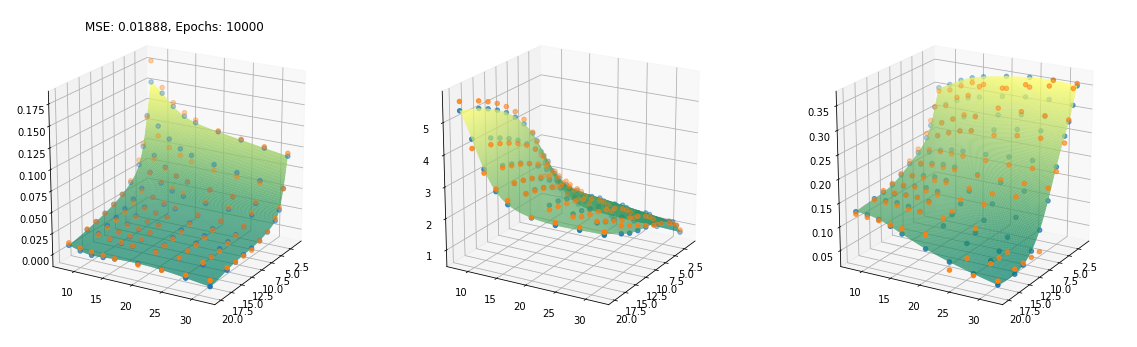

In [29]:
fig = plt.figure(figsize=(20,6))
inputs = x_scaler.inverse_transform(xv.numpy())
ax = []

for i in range(3):
    ax.append(fig.add_subplot(131+i, projection='3d'))
    ax[i].scatter(inputs[:,0], inputs[:,1], y_scaler.inverse_transform(yv_.numpy())[:,i], '.', label='pred')
    ax[i].scatter(inputs[:,0], inputs[:,1], y_scaler.inverse_transform(yv.numpy())[:,i], '.', label='data')

    ax[i].plot_surface(test_ms.reshape(200,200), test_rep.reshape(200,200),
                       y_scaler.inverse_transform(y_test.numpy())[:,i].reshape(200,200), rstride=1, cstride=1,
                       cmap='summer', edgecolor='none', label='data')
    ax[i].view_init(20,30)

ax[0].set_title(f"MSE: {loss.item():0.5f}, Epochs: {epochs:d}")

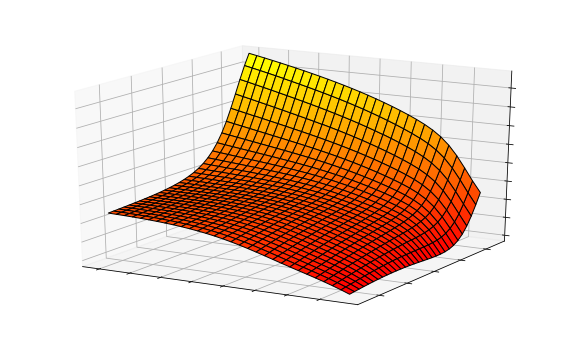

In [57]:
fig = plt.figure(figsize=(10,6))
inputs = x_scaler.inverse_transform(xv.numpy())

ax=(fig.add_subplot(111, projection='3d'))

ax.plot_surface(test_ms.reshape(30,30), test_rep.reshape(30,30),
                   y_scaler.inverse_transform(y_test.numpy())[:,1].reshape(30,30), rstride=1, cstride=1,
                   cmap='autumn', edgecolor='black', label='data')
ax.view_init(20,120)

ax.set_zticklabels([])
ax.set_yticklabels([])
ax.set_xticklabels([])
fig.savefig('rand.png', bbox_inches="tight", dpi=600, transparent=True, pad_inches=0)

### Generation and regression of data for Vapour Liquid Phase Diagram

For the vapour-liquid envelope, we can generate data of these Mie molecules with the same process described above for n-hexane system. For this, on top of the $m_s$ and $\lambda_r$ as inputs, we also have one more degree of freedom which we can set as input. It could be either:
1. Use $m_s$, $\lambda_r$ and $T$ to predict $P_v$, $v_l$ and $v_v$
2. Use $m_s$, $\lambda_r$ and $P$ to predict $T$, $v_l$ and $v_v$
3. Use $m_s$, $\lambda_r$ and $v$ to get a $P$, $T$, although this does not make too much sense. However, it does create the nice vapour liquid envelope that we want to show

In [5]:
# For VLE of Mie Fluids in pure_system defined previously

ms_inputs = np.array([])
rep_inputs = np.array([])
temp_inputs = np.array([])

pv_outputs = np.array([])
rhol_outputs = np.array([])
rhov_outputs = np.array([])

start_time = time.time()

for i in range(len(pure_systems)):
    pure_sys = pure_systems[i]
    ms = ms_data[i]
    rep = rep_data[i]
    t_crit = tc_data[i]
    
    tpoints = 20
    temp_range = epsi_scale * np.linspace(t_crit*0.5, t_crit*0.995, tpoints)
    
    for j in range(tpoints):
        t = temp_range[j]
        
        try:
            if j == 0:
                ig = (1 * ms *(sig_scale * nmtom)**3 * avo, 100*ms*(sig_scale * nmtom)**3 * avo)
            else:
                ig = vle
            pv, vle = pure_sys.vapour_pressure(t, initial_guess=ig, get_volume=True, print_results=False)
            if abs(vle[0] - vle[1]) < 1e-6:
                print()
                print(f'VLE points solver failed to converge at meaningful results at T={t:5.2f}, points too similar ({vle[0]:7.3e}, {vle[1]:7.3e})')
                vle = ig
            else:
                ms_inputs = np.append(ms_inputs, ms)
                rep_inputs = np.append(rep_inputs, rep)
                temp_inputs = np.append(temp_inputs, t/epsi_scale)
                pv_outputs = np.append(pv_outputs, pv * (sig_scale * nmtom)**3 / (epsi_scale * kb))
                rhol_outputs = np.append(rhol_outputs, 1/min(vle) * avo * (sig_scale * nmtom)**3)
                rhov_outputs = np.append(rhov_outputs, 1/max(vle) * avo * (sig_scale * nmtom)**3)
        except:
            print()
            print('VLE solver failed at T={t:5.2f} due to out of range operations. Current point aborted.')
            
        elapsed_time = time.time() - start_time
        print(f'VLE data generation at {int((j+1)*100/tpoints):3d}% complete, time elapsed: {elapsed_time:5.2f} s, vle (ms={ms:3.1f},rep={rep:3.1f}) results ({vle[0]:7.3e}, {vle[1]:7.3e})', end='\r')
    print(f'Data generation complete for pure system (ms={ms:3.1f},rep={rep:3.1f})', ' '*40)


VLE data generation at  95% complete, time elapsed: 28.95 s, vle (ms=1.0,rep=8.0) results (3.667e-05, 9.661e-05)
VLE points solver failed to converge at meaningful results at T=443.46, points too similar (8.304e-05, 8.304e-05)
Data generation complete for pure system (ms=1.0,rep=8.0)                     .0) results (8.304e-05, 8.304e-05)
VLE data generation at  95% complete, time elapsed: 59.29 s, vle (ms=1.0,rep=10.0) results (3.555e-05, 9.907e-05)
VLE points solver failed to converge at meaningful results at T=367.69, points too similar (6.273e-05, 6.280e-05)
Data generation complete for pure system (ms=1.0,rep=10.0)                     .0) results (6.273e-05, 6.280e-05)
VLE data generation at  95% complete, time elapsed: 103.12 s, vle (ms=1.0,rep=12.0) results (3.427e-05, 1.012e-04)
VLE points solver failed to converge at meaningful results at T=325.87, points too similar (1.006e-04, 1.006e-04)
Data generation complete for pure system (ms=1.0,rep=12.0)                     2.0) resul

VLE data generation at  95% complete, time elapsed: 848.23 s, vle (ms=3.0,rep=32.0) results (1.028e-04, 4.107e-04)
VLE points solver failed to converge at meaningful results at T=317.14, points too similar (2.065e-04, 2.067e-04)
Data generation complete for pure system (ms=3.0,rep=32.0)                     2.0) results (2.065e-04, 2.067e-04)
VLE data generation at  95% complete, time elapsed: 881.22 s, vle (ms=4.0,rep=8.0) results (2.047e-04, 5.664e-04)
VLE points solver failed to converge at meaningful results at T=864.76, points too similar (5.137e-04, 5.137e-04)
Data generation complete for pure system (ms=4.0,rep=8.0)                     8.0) results (5.137e-04, 5.137e-04)
VLE data generation at  95% complete, time elapsed: 908.33 s, vle (ms=4.0,rep=10.0) results (1.919e-04, 5.750e-04)
VLE points solver failed to converge at meaningful results at T=677.67, points too similar (5.526e-04, 5.526e-04)
Data generation complete for pure system (ms=4.0,rep=10.0)                     0.0) r

VLE data generation at  95% complete, time elapsed: 1969.75 s, vle (ms=10.0,rep=32.0) results (1.761e-03, 1.761e-03)
VLE points solver failed to converge at meaningful results at T=452.17, points too similar (1.761e-03, 1.761e-03)
Data generation complete for pure system (ms=10.0,rep=32.0)                     32.0) results (1.761e-03, 1.761e-03)
VLE data generation at  95% complete, time elapsed: 1997.18 s, vle (ms=12.0,rep=8.0) results (8.307e-04, 2.718e-03)
VLE points solver failed to converge at meaningful results at T=1238.70, points too similar (2.322e-03, 2.322e-03)
Data generation complete for pure system (ms=12.0,rep=8.0)                     =8.0) results (2.322e-03, 2.322e-03)
VLE data generation at  95% complete, time elapsed: 2026.60 s, vle (ms=12.0,rep=10.0) results (7.970e-04, 2.859e-03)
VLE points solver failed to converge at meaningful results at T=942.77, points too similar (1.960e-03, 1.960e-03)
Data generation complete for pure system (ms=12.0,rep=10.0)               

Data generation complete for pure system (ms=16.0,rep=10.0)                     10.0) results (2.351e-03, 2.359e-03)
VLE data generation at  95% complete, time elapsed: 2634.27 s, vle (ms=16.0,rep=12.0) results (1.130e-03, 4.632e-03)
VLE points solver failed to converge at meaningful results at T=842.87, points too similar (4.183e-03, 4.183e-03)
Data generation complete for pure system (ms=16.0,rep=12.0)                     12.0) results (4.183e-03, 4.183e-03)
VLE data generation at  95% complete, time elapsed: 2664.61 s, vle (ms=16.0,rep=14.0) results (1.123e-03, 4.816e-03)
VLE points solver failed to converge at meaningful results at T=742.76, points too similar (3.881e-03, 3.881e-03)
Data generation complete for pure system (ms=16.0,rep=14.0)                     14.0) results (3.881e-03, 3.881e-03)
VLE data generation at  95% complete, time elapsed: 2698.19 s, vle (ms=16.0,rep=16.0) results (1.123e-03, 5.029e-03)
VLE points solver failed to converge at meaningful results at T=674.20

VLE data generation at  85% complete, time elapsed: 3074.17 s, vle (ms=20.0,rep=28.0) results (6.609e-03, 6.609e-03)
VLE points solver failed to converge at meaningful results at T=583.80, points too similar (6.609e-03, 6.609e-03)
VLE data generation at  90% complete, time elapsed: 3074.62 s, vle (ms=20.0,rep=28.0) results (6.609e-03, 6.609e-03)
VLE points solver failed to converge at meaningful results at T=599.93, points too similar (6.609e-03, 6.609e-03)
VLE data generation at  95% complete, time elapsed: 3075.04 s, vle (ms=20.0,rep=28.0) results (6.609e-03, 6.609e-03)
VLE points solver failed to converge at meaningful results at T=616.06, points too similar (6.609e-03, 6.609e-03)
Data generation complete for pure system (ms=20.0,rep=28.0)                     28.0) results (6.609e-03, 6.609e-03)
VLE data generation at  60% complete, time elapsed: 3100.67 s, vle (ms=20.0,rep=32.0) results (4.487e-03, 4.496e-03)
VLE points solver failed to converge at meaningful results at T=506.73, p

In [8]:
print(np.size(pv_outputs)/(20*99))

0.9464646464646465


In [11]:
# Saving data, comment this block if you do not want to save the data.
df = pd.DataFrame(np.column_stack([ms_inputs, rep_inputs, temp_inputs, pv_outputs, rhol_outputs, rhov_outputs]))
outputfile = 'saftgmie_vle_data.csv'
df.to_csv(outputfile, index=False, header=['ms', 'lambda_r', 't', 'pv', 'rhol', 'rhov'])
print()
print(f'Data generation complete. Output file: {outputfile}', ' '*5)



Data generation complete. Output file: saftgmie_vle_data.csv      


In [30]:
# Reading data (if we have already generated)
inputfile = 'saftgmie_vle_data.csv'
df = pd.read_csv(inputfile)

ms_inputs = df.iloc[:,0].values
rep_inputs = df.iloc[:,1].values
temp_inputs = df.iloc[:,2].values
pv_outputs = df.iloc[:,3].values
rhol_outputs = df.iloc[:,4].values
rhov_outputs = df.iloc[:,4].values

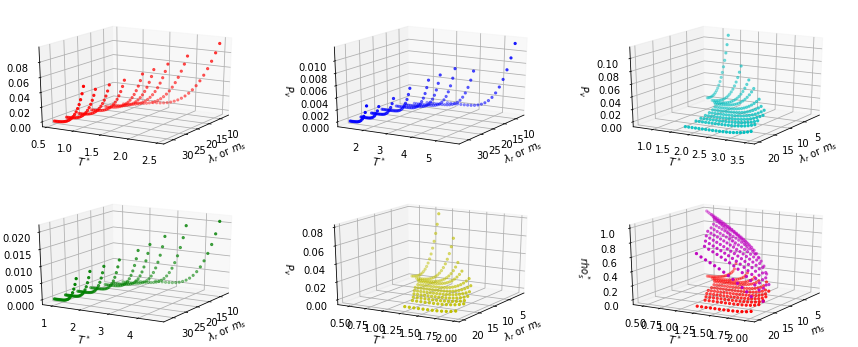

In [31]:
ms2_only = df.loc[df.iloc[:,0] == 2.0]
ms20_only = df.loc[df.iloc[:,0] == 20.0]
rep12_only = df.loc[df.iloc[:,1] == 12.0]
ms10_only = df.loc[df.iloc[:,0] == 10.0]
rep32_only = df.loc[df.iloc[:,1] == 32.0]
rep28_only = df.loc[df.iloc[:,1] == 28.0]

fig = plt.figure(figsize=(15,6))
ax = []
all_x = [ms2_only.iloc[:,1].values,
         ms20_only.iloc[:,1].values,
         rep12_only.iloc[:,0].values,
         ms10_only.iloc[:,1].values,
         rep32_only.iloc[:,0].values,
         rep28_only.iloc[:,0].values]
all_y = [ms2_only.iloc[:,2].values,
         ms20_only.iloc[:,2].values,
         rep12_only.iloc[:,2].values,
         ms10_only.iloc[:,2].values,
         rep32_only.iloc[:,2].values,
         rep28_only.iloc[:,2].values]

all_z = [ms2_only.iloc[:,3].values,
         ms20_only.iloc[:,3].values,
         rep12_only.iloc[:,3].values,
         ms10_only.iloc[:,3].values,
         rep32_only.iloc[:,3].values,
         rep28_only.iloc[:,3].values]
c = list('rbcgym')
for i in range(5):
    ax.append(fig.add_subplot(231+i, projection="3d"))
    ax[i].scatter(all_x[i], all_y[i], all_z[i], c=c[i], marker='.')
    ax[i].set_xlabel('$\lambda_r$ or $m_s$')
    ax[i].set_ylabel('$T^*$')
    ax[i].set_zlabel('$P_v$')
    ax[i].view_init(20,30)

ax.append(fig.add_subplot(236, projection="3d"))
ax[5].scatter(all_x[5], all_y[5], rep28_only.iloc[:,4].values*all_x[5], c=c[5], marker='.')
ax[5].scatter(all_x[5], all_y[5], rep28_only.iloc[:,5].values*all_x[5], c=c[0], marker='.')
ax[5].set_xlabel('$m_s$')
ax[5].set_ylabel('$T^*$')
ax[5].set_zlabel('$rho_s^*$')
ax[5].view_init(20,30)
    

Now we can also attempt to use GPR and deep learning to create a regression for vapour pressure, liquid and vapour phase boundary (separately) with a 3 inputs to 3 outputs model. Let's try this with both GPR and ANN.

In [115]:
# 3 inputs - 3 outputs data model

x_scaler = preprocessing.StandardScaler()
x_train = x_scaler.fit_transform(np.column_stack([ms_inputs, rep_inputs, temp_inputs]))
y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(np.column_stack([pv_outputs, rhol_outputs, rhov_outputs]))

x = torch.from_numpy(x_train).float()
y = torch.from_numpy(y_train).float()
xv = torch.from_numpy(x_train).float()
yv = torch.from_numpy(y_train).float()

model_vle = SimpleNet((3,3), [30,10], [nn.Tanh(), nn.ReLU()])
optimizer = optim.SGD(model_vle.parameters(), lr=0.01)
criterion = nn.MSELoss()
epochs = 0

In [116]:
for i in range(10000):
    model_vle.train()
    optimizer.zero_grad()

    y_ = model_vle(x)
    loss = criterion(y_, y)

    # print('epoch: ', epoch,' loss: ', loss.item())
    loss.backward()
    optimizer.step()
    epochs += 1

model_vle.eval()
with torch.no_grad():
    yv_ = model_vle(xv)
    loss = criterion(yv_, yv)

test_ms = np.repeat(np.repeat(np.linspace(1,20,50), 50), 50)
test_rep = np.repeat(np.tile(np.linspace(8,32,50), 50), 50)
test_t = np.tile(np.tile(np.linspace(0.5,5,50), 50), 50)
x_test = torch.from_numpy(x_scaler.transform(np.column_stack([test_ms, test_rep, test_t]))).float()

with torch.no_grad():
    y_test = model_vle(x_test)

In [136]:
x_ = x_scaler.inverse_transform(x_test.numpy())
y_ = y_scaler.inverse_transform(y_test.numpy())
x_show = x_[(x_[:,1]<=12.0) & (x_[:,1]>11.9),:]
y_show = y_[(x_[:,1]<=12.0) & (x_[:,1]>11.9),:]

print(y_show)

[[-1.5025881e-02  8.9090890e-01  9.0411359e-01]
 [-7.9675233e-03  8.6056274e-01  8.7306285e-01]
 [ 6.4572610e-05  8.2625169e-01  8.3707231e-01]
 ...
 [ 2.6296342e-03  1.5443479e-02  4.2476398e-03]
 [ 2.7093829e-03  1.4532332e-02  2.2711051e-03]
 [ 2.7930483e-03  1.3555531e-02  1.5756907e-04]]


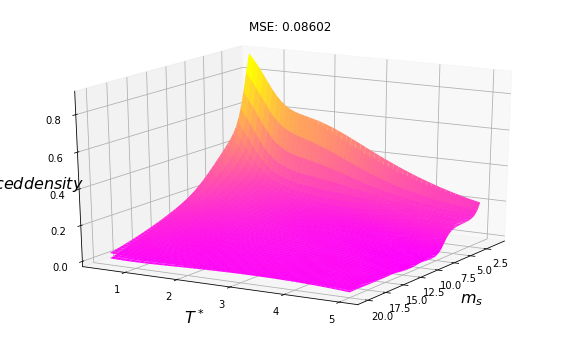

In [139]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')
# ax.scatter(inputs[:,0], inputs[:,1], y_scaler.inverse_transform(yv_.numpy()), '.', label='pred')
ax.scatter(inputs[:,0], inputs[:,1], y_scaler.inverse_transform(yv.numpy()), '.', label='data')

ax.plot_surface(x_show[:,0].reshape(50,50), x_show[:,2].reshape(50,50),
                y_show[:,1].reshape(50,50), rstride=1, cstride=1,
                cmap='spring', edgecolor='none', label='data')

ax.plot_surface(x_show[:,0].reshape(50,50), x_show[:,2].reshape(50,50),
                y_show[:,2].reshape(50,50), rstride=1, cstride=1,
                cmap='spring', edgecolor='none', label='data')

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('$m_s$',fontsize=16,labelpad=10)
ax.set_ylabel('$T^*$',fontsize=16,labelpad=10)
ax.set_zlabel('$Reduced density$',fontsize=16,labelpad=10)
ax.set_title(f"MSE: {loss.item():0.5f}")
ax.view_init(20,30)
fig.savefig('ljvle.png', bbox_inches="tight", dpi=600, transparent=True, pad_inches=0)

In [ ]:
pc_data = np.array([])
tc_data = np.array([])
rhoc_data = np.array([])

start_time = time.time()
for i in range(1,len(pure_systems)):
    pure_sys = pure_systems[i]
    if i == 0:
        ig = (2*ms_data[i]*(sig_scale * nmtom)**3 * avo, epsi_scale)
        # Note: critical rho must be lower than rhos* = 1 and higher than T* = 1
    else:
        ig = (2*ms_data[i]*(sig_scale * nmtom)**3 * avo, (i+1)**0.7 * epsi_scale)
    print(f'Initial guess: {ig[0]:7.3e}, {ig[1]:7.3e}, v bounds: ({ig[0]*.1:7.3e},{ig[0]*10:7.3e}), T bounds: ({ig[1]*.1:7.3e},{ig[1]*10:7.3e})')
    (pc, tc, rhoc) = pure_sys.get_critical_point(initial_guess=ig, get_density=True,
                                                 print_results=True, print_progress=True, xtol=1e-12,
                                                 solver_kwargs={'bounds': ((.1,.1), (10,2)), 'gtol': 1e-8, 
                                                                'ftol': 1e-15, 'method': 'trf'})
    pc_s = pc * (sig_scale * nmtom)**3 / (epsi_scale * kb)
    tc_s = tc / epsi_scale
    rhoc_s = rhoc * avo * (sig_scale * nmtom)**3
    elapsed_time = time.time() - start_time
    print(f'Current status: rep={rep_data[i]:5.2f},ms={int(ms_data[i]):d}, results: ({pc_s:5.3f}, {tc_s:5.3f}, {rhoc_s:5.3f}), elapsed time: {elapsed_time:6.3f}s')
    print()
    pc_data = np.append(pc_data, pc_s)
    tc_data = np.append(tc_data, tc_s)
    rhoc_data = np.append(rhoc_data, rhoc_s)

[437.5 440.  442.5 445.  447.5 450. ]


Text(0.5,1,'PV Isotherm')

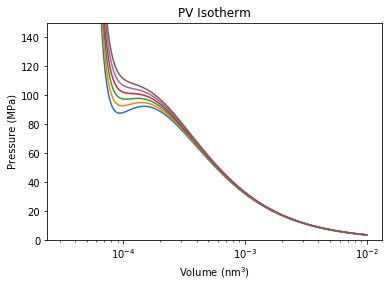

In [6]:
fig, ax = plt.subplots()
T = 250 * np.array([1.75,1.76,1.77,1.78,1.79,1.8])
print(T)
# for t in [490]:
#     testpv, testvle = pure_hexane.vapour_pressure(t,initial_guess=(0.0002,0.06), get_volume=True, print_results=True)
#     print(f'{t:d}: {testvle[0]:7.4e}, {testvle[1]:7.4e}')

v = np.logspace(-4.5, -2, 200)

with io.capture_output() as captured:
    for t in T:
        p,g = pure_systems[1].p_v_isotherm(v, temperature=t, gibbs=True)
        ax.semilogx(v,p*1e-5,'-')
# ax.semilogx([6.958e-05,6.958e-05], [0,30], 'k-')
# ax.semilogx([testvle[1], testvle[1]], [0,30e5], 'k-')
ax.set_ylim((0,150))

# ax2 = ax.twinx()
# ax2.semilogx(v,g*6.023e23,'r-')
# ax2.set_ylim((8e3, 1e5))
ax.set_ylabel("Pressure (MPa)")
ax.set_xlabel("Volume (nm$^{3}$)")
ax.set_title("PV Isotherm")

# fig, ax = plt.subplots()
# x = np.linspace(0,1, 1000)
# y1 = 1/(1-x)
# y2 = 1/(1-x**2)
# ax.plot(x,y1,'-')
# ax.plot(x,y2,'-')
# x0size = 50
# x1size = 50
# x0 = np.linspace(1e-5,1,x0size)
# x1 = np.repeat(np.linspace(1e-5,1,x1size), x0size)
# x0 = np.tile(x0, x1size)
# value = 1/(1-abs(x0/x1))

# ax.plot_trisurf(x0,x1,value,linewidth=0.2, antialiased=True,cmap=plt.cm.CMRmap)